## Train DCGAN and WGAN-GP to generate segmentation masks<a name='train_dcgan'>

Synthetic segmentation masks will augment the dataset of ground truth segmentation from ISIC 2018 Melanoma dataset.

In [115]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Activation, Conv2D, BatchNormalization, UpSampling2D, GaussianNoise, LeakyReLU, Dropout, AveragePooling2D, Flatten, Dense
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import ceil

In [3]:
MASK_DIR = 'dataset_200'
IMAGE_SIZE = 256
BATCH_SIZE = 16

In [4]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [5]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [6]:
def get_generator():
    generator = tf.keras.Sequential([
        Reshape(target_shape=[1, 1, 4096], input_shape=[4096]),

        # 1x1x4096
        Conv2DTranspose(filters=256, kernel_size=4),
        Activation('relu'),

        # 4x4x256 - kernel sized increased by 1
        Conv2D(filters=256, kernel_size=4, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 8x8x256 - kernel sized increased by 1
        Conv2D(filters=128, kernel_size=4, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 16x16x128
        Conv2D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 32x32x64
        Conv2D(filters=32, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 64x64x32
        Conv2D(filters=16, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 128x128x16
        Conv2D(filters=8, kernel_size=3, padding='same'),
        Activation('relu'),
        UpSampling2D(),

        # 256x256x8
        Conv2D(filters=1, kernel_size=3, padding='same'),
        Activation('sigmoid')
    ])
    return generator

In [7]:
def get_discriminator():
    discriminator = tf.keras.Sequential([
        # 256x256x1 Image
        Conv2D(filters=8, kernel_size=3, padding='same'),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 128x128x8
        Conv2D(filters=16, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 64x64x16
        Conv2D(filters=32, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 32x32x32
        Conv2D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 16x16x64
        Conv2D(filters=128, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 8x8x128
        Conv2D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 4x4x256
        Flatten(),

        # 256
        Dense(128),
        LeakyReLU(0.2),

        Dense(1, activation='sigmoid')
    ])
    return discriminator

In [8]:
def binarize(mask):
    mask[mask > 0] = 1
    return mask

In [9]:
mask_generator = ImageDataGenerator(
    preprocessing_function=binarize
)

mask_generator = mask_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=MASK_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode=None,
    seed=1,
    classes=['dcgan_masks'],
    color_mode='grayscale',
)

train_masks = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, mask_generator),
    output_types=(tf.float32),
    output_shapes=[None, 256, 256, 1]
)


Found 200 images belonging to 1 classes.


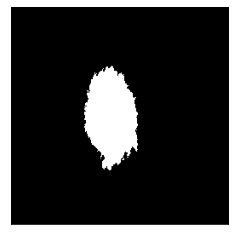

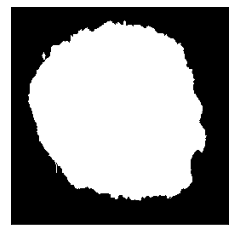

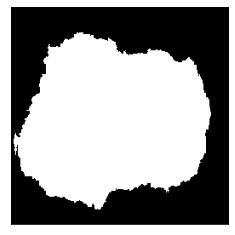

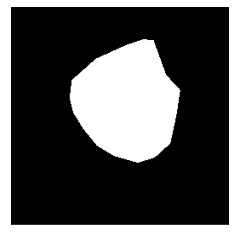

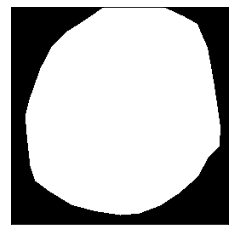

In [10]:
masks = next(mask_generator)

for m in list(masks)[:5]:
    fig = plt.imshow(m, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [19]:
generator = get_generator()
discriminator = get_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [20]:
class DCGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, noise_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_dim = noise_dim

    def compile(self, d_optimizer, g_optimizer, d_loss, g_loss):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss
        
    def train_step(self, images):
        noise = tf.random.normal([BATCH_SIZE, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            g_loss_val = self.g_loss(fake_output)
            d_loss_val = self.d_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(
                g_loss_val, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(
                d_loss_val, self.discriminator.trainable_variables)

            self.g_optimizer.apply_gradients(
                zip(gradients_of_generator, self.generator.trainable_variables))
            self.d_optimizer.apply_gradients(
                zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {'d_loss': d_loss_val, 'g_loss': g_loss_val}

In [21]:
EPOCHS = 100
NOISE_DIM = 4096
IMAGES_COUNT = 200

In [37]:
class ImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_mask = self.model.generator(noise, training=True).numpy()
        generated_mask[generated_mask < 0.5] = 0
        generated_mask[generated_mask >= 0.5] = 1
        
        plt.imshow(generated_mask[0], cmap='gray')
        plt.show()

In [38]:
LOG_DIR = 'dcgan/logs/'
board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

In [39]:
gan = DCGAN(discriminator=discriminator,
            generator=generator, noise_dim=NOISE_DIM)

image_callback = ImageCallback(gan)

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [31]:
class SaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, save_dir):
        self.model = model
        self.save_dir = save_dir
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                              discriminator_optimizer=discriminator_optimizer,
                                              generator=generator,
                                              discriminator=discriminator)

    def on_epoch_end(self, epoch, logs=None):
        print(f'Save checkpoint')
        self.checkpoint.write(self.save_dir)

Epoch 1/100
12/12 [==============================] - 4s 224ms/step - d_loss: 0.2566 - g_loss: 4.5327
Save checkpoint


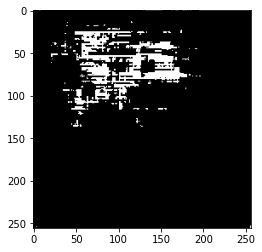

Epoch 2/100
12/12 [==============================] - 2s 189ms/step - d_loss: 0.1487 - g_loss: 3.0759
Save checkpoint


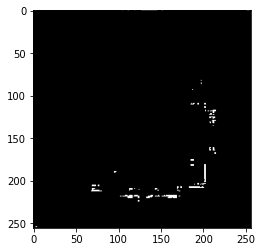

Epoch 3/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.0486 - g_loss: 4.7640
Save checkpoint


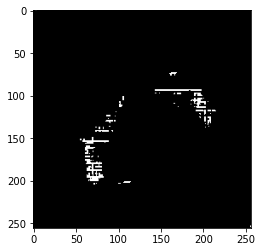

Epoch 4/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.6798 - g_loss: 3.4405
Save checkpoint


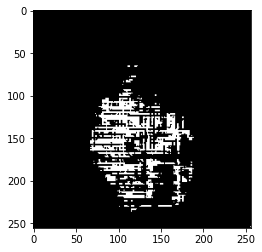

Epoch 5/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.7166 - g_loss: 3.2223
Save checkpoint


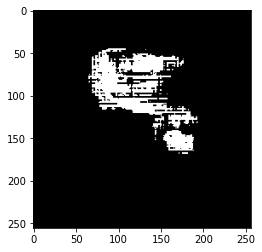

Epoch 6/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.2934 - g_loss: 2.5189
Save checkpoint


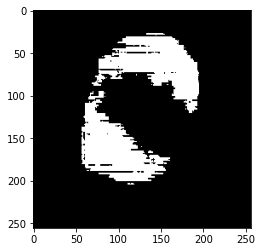

Epoch 7/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.6437 - g_loss: 2.7801
Save checkpoint


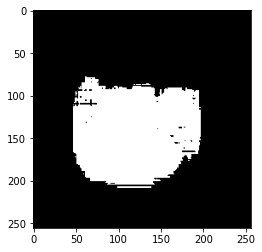

Epoch 8/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.2423 - g_loss: 2.7464
Save checkpoint


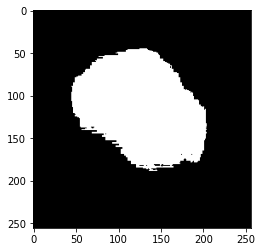

Epoch 9/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.6082 - g_loss: 3.1369
Save checkpoint


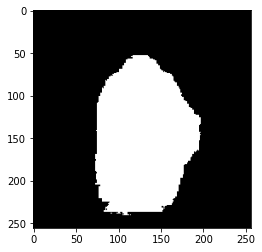

Epoch 10/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9625 - g_loss: 2.5048
Save checkpoint


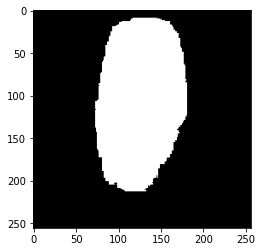

Epoch 11/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.3357 - g_loss: 3.2453
Save checkpoint


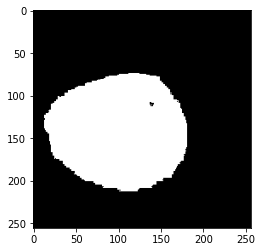

Epoch 12/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.6529 - g_loss: 2.6416
Save checkpoint


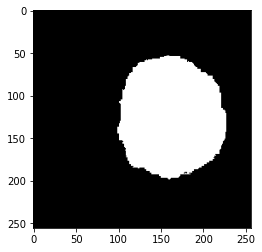

Epoch 13/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9760 - g_loss: 3.1240
Save checkpoint


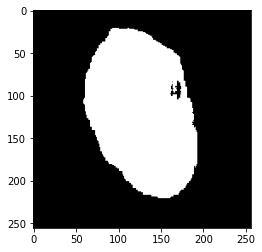

Epoch 14/100
12/12 [==============================] - 2s 189ms/step - d_loss: 0.6408 - g_loss: 1.8661
Save checkpoint


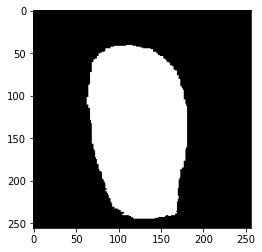

Epoch 15/100
12/12 [==============================] - 2s 189ms/step - d_loss: 0.9191 - g_loss: 1.6456
Save checkpoint


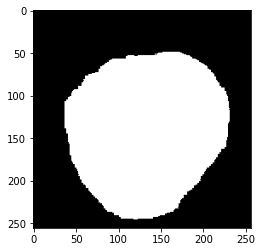

Epoch 16/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9482 - g_loss: 1.8613
Save checkpoint


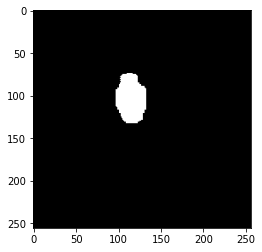

Epoch 17/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9200 - g_loss: 1.7976
Save checkpoint


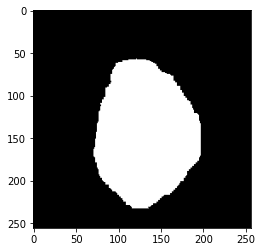

Epoch 18/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0381 - g_loss: 1.4143
Save checkpoint


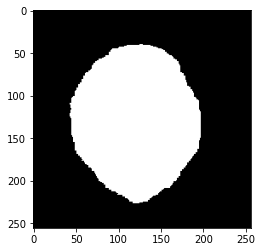

Epoch 19/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.1416 - g_loss: 1.5552
Save checkpoint


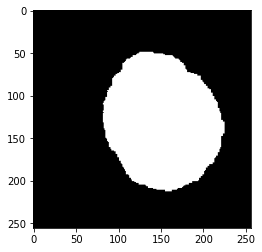

Epoch 20/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9789 - g_loss: 1.5363
Save checkpoint


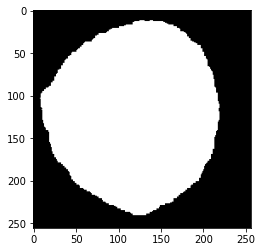

Epoch 21/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8343 - g_loss: 1.6749
Save checkpoint


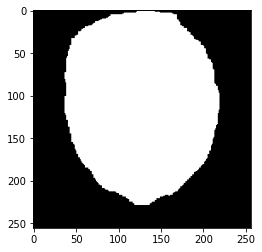

Epoch 22/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8788 - g_loss: 1.7087
Save checkpoint


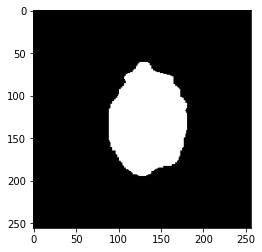

Epoch 23/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0763 - g_loss: 1.5239
Save checkpoint


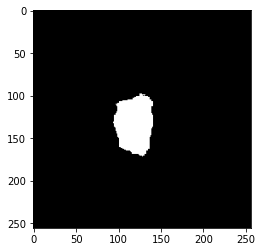

Epoch 24/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.8897 - g_loss: 1.4570
Save checkpoint


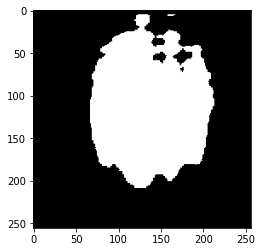

Epoch 25/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.2599 - g_loss: 1.3362
Save checkpoint


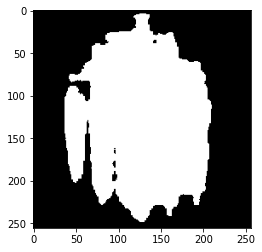

Epoch 26/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0382 - g_loss: 1.3686
Save checkpoint


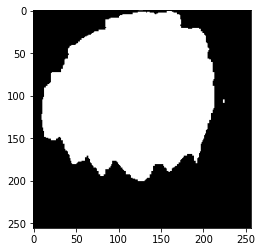

Epoch 27/100
12/12 [==============================] - 2s 190ms/step - d_loss: 1.1432 - g_loss: 1.3678
Save checkpoint


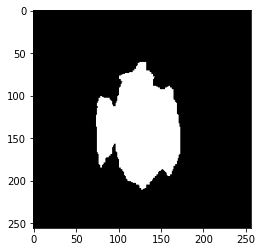

Epoch 28/100
12/12 [==============================] - 2s 189ms/step - d_loss: 1.0528 - g_loss: 1.4929
Save checkpoint


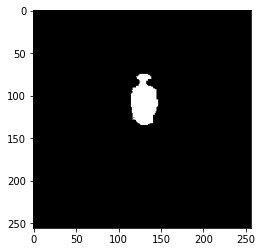

Epoch 29/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.8618 - g_loss: 1.6888
Save checkpoint


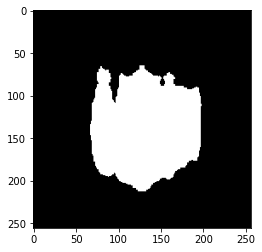

Epoch 30/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0045 - g_loss: 1.6928
Save checkpoint


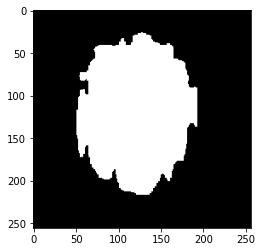

Epoch 31/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0899 - g_loss: 1.2615
Save checkpoint


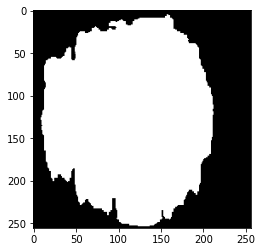

Epoch 32/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.1866 - g_loss: 1.3163
Save checkpoint


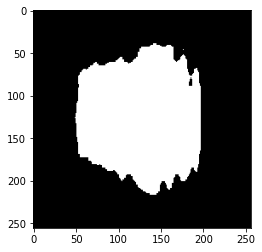

Epoch 33/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9984 - g_loss: 1.2078
Save checkpoint


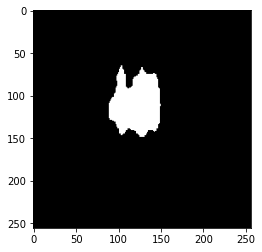

Epoch 34/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0087 - g_loss: 1.3849
Save checkpoint


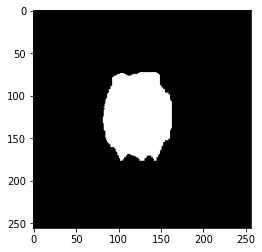

Epoch 35/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.1315 - g_loss: 1.4118
Save checkpoint


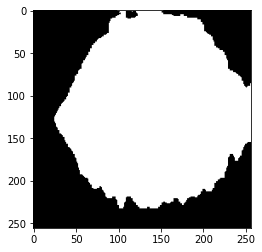

Epoch 36/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0504 - g_loss: 1.3244
Save checkpoint


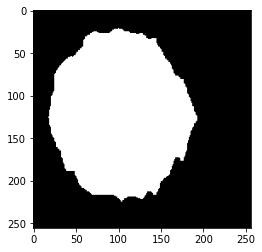

Epoch 37/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9793 - g_loss: 1.1611
Save checkpoint


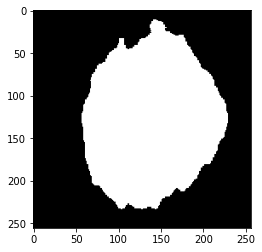

Epoch 38/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.5790 - g_loss: 2.1600
Save checkpoint


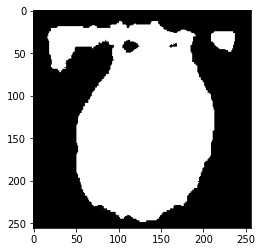

Epoch 39/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.1470 - g_loss: 1.6553
Save checkpoint


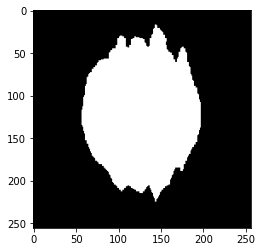

Epoch 40/100
12/12 [==============================] - 2s 189ms/step - d_loss: 0.9752 - g_loss: 1.4712
Save checkpoint


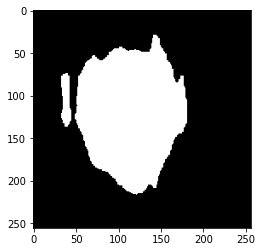

Epoch 41/100
12/12 [==============================] - 2s 190ms/step - d_loss: 1.0789 - g_loss: 1.4702
Save checkpoint


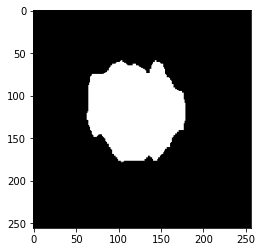

Epoch 42/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0053 - g_loss: 1.3895
Save checkpoint


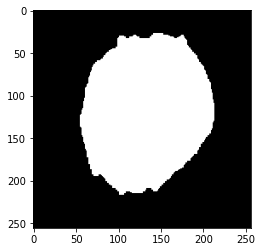

Epoch 43/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0668 - g_loss: 1.4481
Save checkpoint


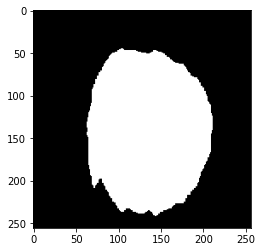

Epoch 44/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0537 - g_loss: 1.3476
Save checkpoint


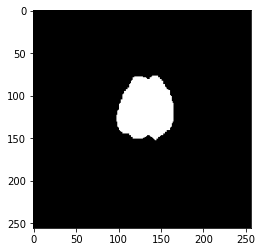

Epoch 45/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9410 - g_loss: 1.2684
Save checkpoint


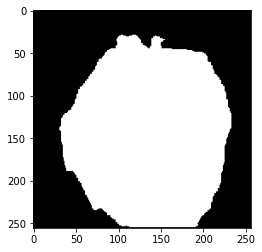

Epoch 46/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9704 - g_loss: 1.4398
Save checkpoint


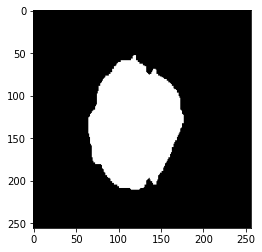

Epoch 47/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0874 - g_loss: 1.3412
Save checkpoint


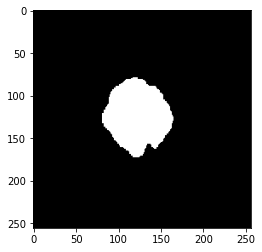

Epoch 48/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0310 - g_loss: 1.5475
Save checkpoint


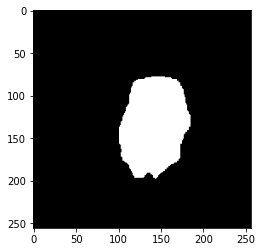

Epoch 49/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9499 - g_loss: 1.4526
Save checkpoint


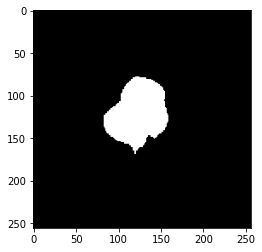

Epoch 50/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.1449 - g_loss: 1.4627
Save checkpoint


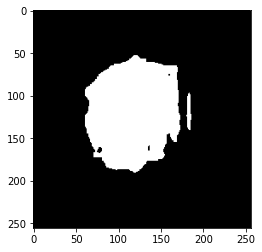

Epoch 51/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9677 - g_loss: 1.5460
Save checkpoint


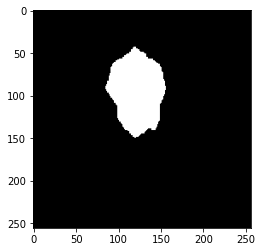

Epoch 52/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.1346 - g_loss: 1.4849
Save checkpoint


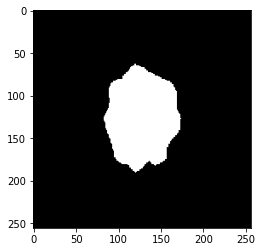

Epoch 53/100
12/12 [==============================] - 2s 190ms/step - d_loss: 0.9045 - g_loss: 1.3561
Save checkpoint


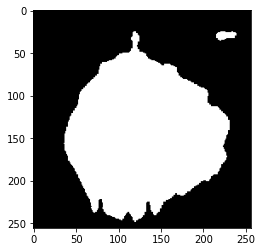

Epoch 54/100
12/12 [==============================] - 2s 190ms/step - d_loss: 1.0715 - g_loss: 1.6819
Save checkpoint


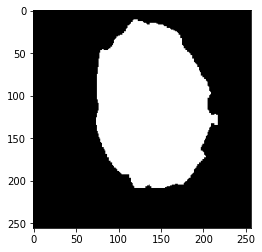

Epoch 55/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9652 - g_loss: 1.4586
Save checkpoint


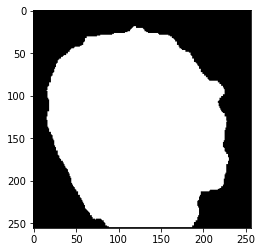

Epoch 56/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0353 - g_loss: 1.3390
Save checkpoint


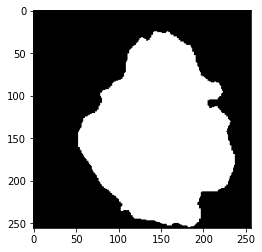

Epoch 57/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9377 - g_loss: 1.3998
Save checkpoint


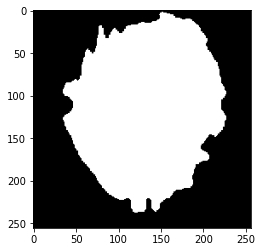

Epoch 58/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0647 - g_loss: 1.5762
Save checkpoint


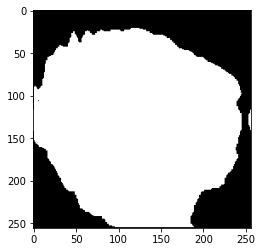

Epoch 59/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9208 - g_loss: 1.4722
Save checkpoint


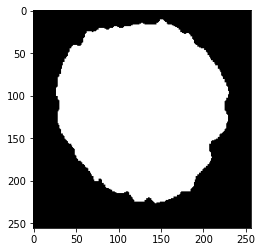

Epoch 60/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0545 - g_loss: 1.4417
Save checkpoint


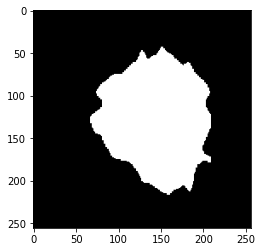

Epoch 61/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8445 - g_loss: 1.3734
Save checkpoint


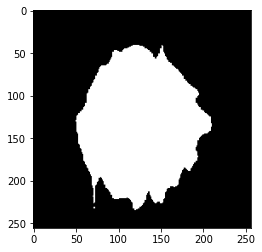

Epoch 62/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0554 - g_loss: 1.5251
Save checkpoint


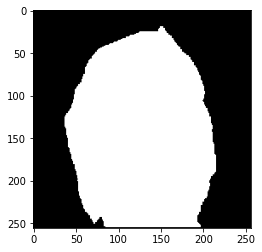

Epoch 63/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9296 - g_loss: 1.8047
Save checkpoint


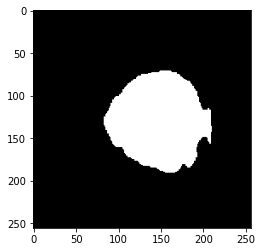

Epoch 64/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8949 - g_loss: 1.7385
Save checkpoint


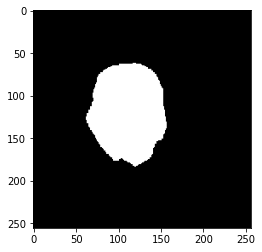

Epoch 65/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0035 - g_loss: 1.3904
Save checkpoint


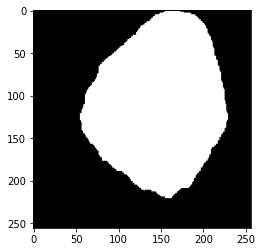

Epoch 66/100
12/12 [==============================] - 2s 189ms/step - d_loss: 0.8022 - g_loss: 1.5225
Save checkpoint


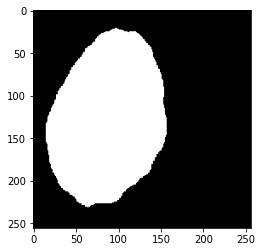

Epoch 67/100
12/12 [==============================] - 2s 189ms/step - d_loss: 1.1286 - g_loss: 1.5919
Save checkpoint


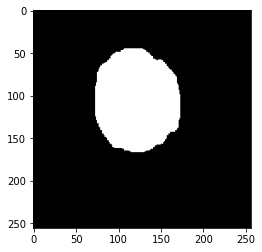

Epoch 68/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.1990 - g_loss: 1.3535
Save checkpoint


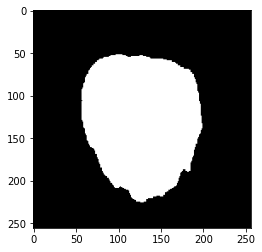

Epoch 69/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8227 - g_loss: 2.0172
Save checkpoint


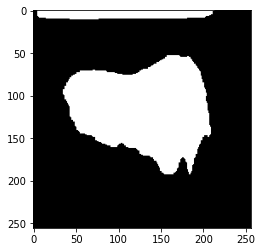

Epoch 70/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8018 - g_loss: 1.6261
Save checkpoint


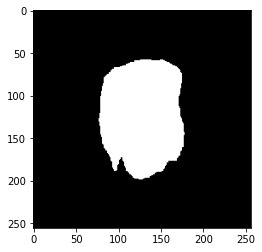

Epoch 71/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.1345 - g_loss: 1.4096
Save checkpoint


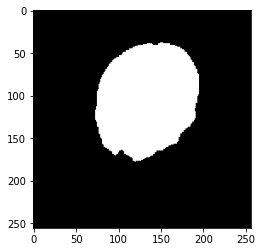

Epoch 72/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.1083 - g_loss: 1.3497
Save checkpoint


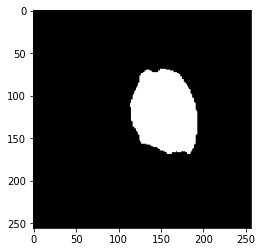

Epoch 73/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9156 - g_loss: 1.4541
Save checkpoint


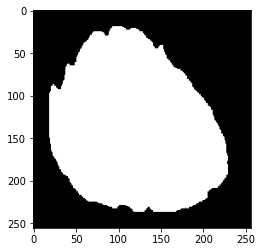

Epoch 74/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0639 - g_loss: 1.2388
Save checkpoint


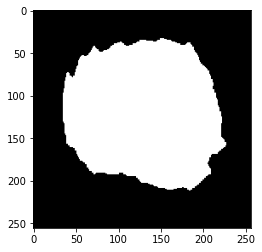

Epoch 75/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.8484 - g_loss: 1.4846
Save checkpoint


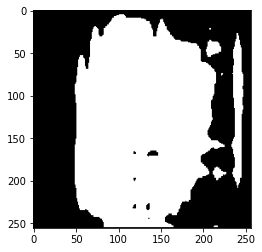

Epoch 76/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0980 - g_loss: 1.6670
Save checkpoint


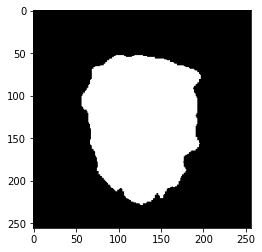

Epoch 77/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.2217 - g_loss: 1.2053
Save checkpoint


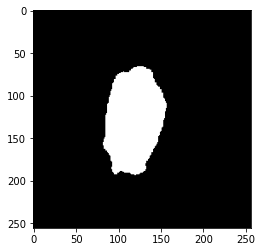

Epoch 78/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9631 - g_loss: 1.5794
Save checkpoint


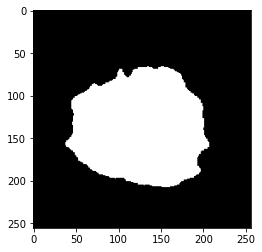

Epoch 79/100
12/12 [==============================] - 2s 189ms/step - d_loss: 1.0559 - g_loss: 1.4449
Save checkpoint


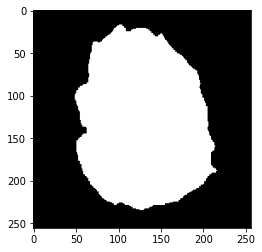

Epoch 80/100
12/12 [==============================] - 2s 190ms/step - d_loss: 1.0185 - g_loss: 1.4496
Save checkpoint


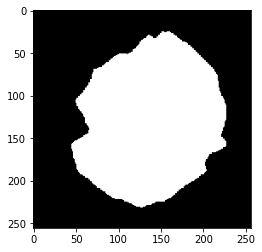

Epoch 81/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.8884 - g_loss: 1.4797
Save checkpoint


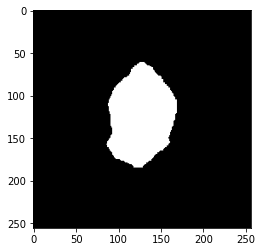

Epoch 82/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.7841 - g_loss: 1.7420
Save checkpoint


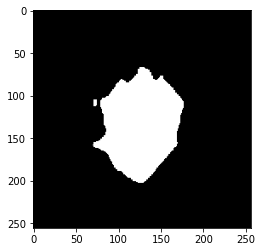

Epoch 83/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9267 - g_loss: 1.5497
Save checkpoint


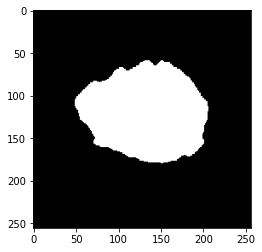

Epoch 84/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0216 - g_loss: 1.9082
Save checkpoint


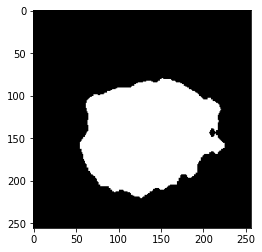

Epoch 85/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.8720 - g_loss: 1.6109
Save checkpoint


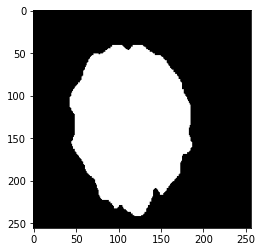

Epoch 86/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9017 - g_loss: 1.8995
Save checkpoint


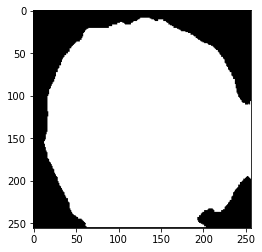

Epoch 87/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0575 - g_loss: 1.5902
Save checkpoint


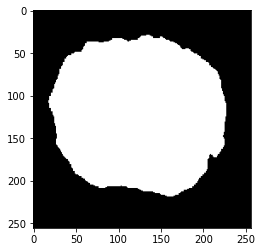

Epoch 88/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8196 - g_loss: 1.7417
Save checkpoint


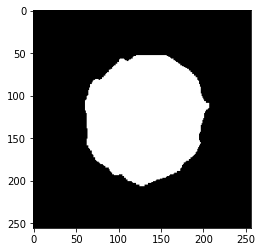

Epoch 89/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.8446 - g_loss: 1.6188
Save checkpoint


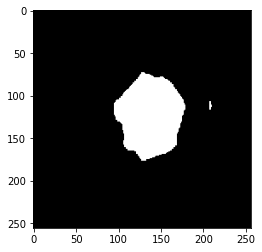

Epoch 90/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0783 - g_loss: 1.7301
Save checkpoint


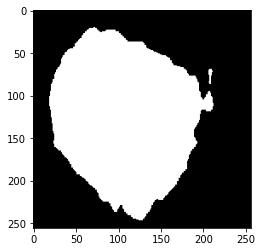

Epoch 91/100
12/12 [==============================] - 2s 188ms/step - d_loss: 1.0187 - g_loss: 1.4099
Save checkpoint


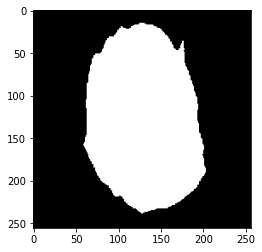

Epoch 92/100
12/12 [==============================] - 2s 190ms/step - d_loss: 1.0748 - g_loss: 1.6450
Save checkpoint


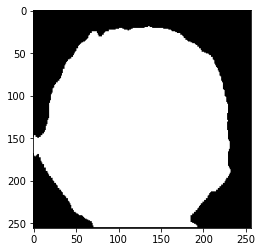

Epoch 93/100
12/12 [==============================] - 2s 189ms/step - d_loss: 0.8220 - g_loss: 1.6122
Save checkpoint


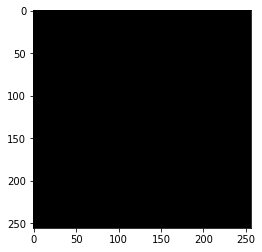

Epoch 94/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0243 - g_loss: 1.6048
Save checkpoint


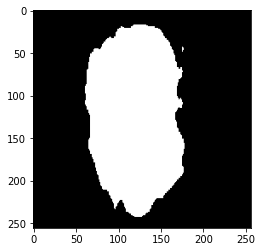

Epoch 95/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.8593 - g_loss: 1.6317
Save checkpoint


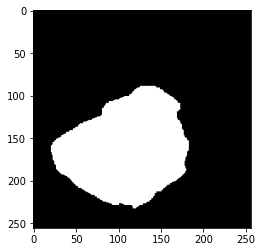

Epoch 96/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0094 - g_loss: 1.5898
Save checkpoint


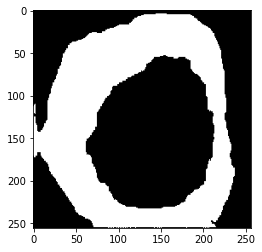

Epoch 97/100
12/12 [==============================] - 2s 187ms/step - d_loss: 1.0156 - g_loss: 1.5473
Save checkpoint


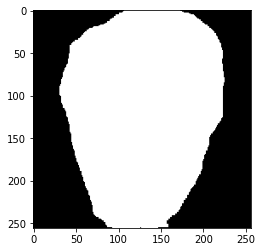

Epoch 98/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.7224 - g_loss: 1.6540
Save checkpoint


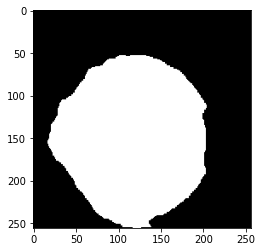

Epoch 99/100
12/12 [==============================] - 2s 188ms/step - d_loss: 0.9114 - g_loss: 1.8130
Save checkpoint


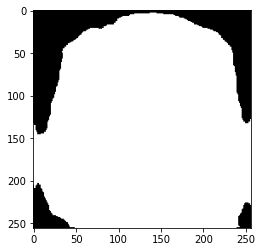

Epoch 100/100
12/12 [==============================] - 2s 187ms/step - d_loss: 0.9510 - g_loss: 1.5889
Save checkpoint


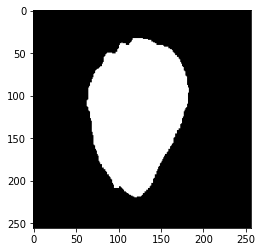

In [42]:
gan.compile(
    d_optimizer=generator_optimizer,
    g_optimizer=discriminator_optimizer,
    d_loss=discriminator_loss,
    g_loss=generator_loss,
)

SAVE_DIR = 'dcgan/checkpoints/last'
save_callback = SaveCallback(gan, SAVE_DIR)

gan.fit(train_masks,
        batch_size=BATCH_SIZE,
        shuffle=False,
        epochs=100,
        steps_per_epoch=ceil(IMAGES_COUNT//BATCH_SIZE),
        callbacks=[save_callback, board_callback, image_callback]
        )

In [43]:
%load_ext tensorboard
%tensorboard --logdir dcgan/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 87332), started 1:00:33 ago. (Use '!kill 87332' to kill it.)

### Generate 80 synthetic segmentation masks to augment the dataset<a name='generate_masks'></a>

In [49]:
from keras.preprocessing.image import save_img

In [51]:
SYNTHETIC_MASKS_COUNT = 80

noise = tf.random.normal([SYNTHETIC_MASKS_COUNT, NOISE_DIM])
generated_images = generator(noise, training=False).numpy()
for i, m in enumerate(generated_images):
    save_img(f'dataset_200/synthetic/mask/{i}.png', m)
    print(f'Mask dataset_200/synthetic/mask/{i}.png saved')

Mask dataset_200/synthetic/mask/0.png saved
Mask dataset_200/synthetic/mask/1.png saved
Mask dataset_200/synthetic/mask/2.png saved
Mask dataset_200/synthetic/mask/3.png saved
Mask dataset_200/synthetic/mask/4.png saved
Mask dataset_200/synthetic/mask/5.png saved
Mask dataset_200/synthetic/mask/6.png saved
Mask dataset_200/synthetic/mask/7.png saved
Mask dataset_200/synthetic/mask/8.png saved
Mask dataset_200/synthetic/mask/9.png saved
Mask dataset_200/synthetic/mask/10.png saved
Mask dataset_200/synthetic/mask/11.png saved
Mask dataset_200/synthetic/mask/12.png saved
Mask dataset_200/synthetic/mask/13.png saved
Mask dataset_200/synthetic/mask/14.png saved
Mask dataset_200/synthetic/mask/15.png saved
Mask dataset_200/synthetic/mask/16.png saved
Mask dataset_200/synthetic/mask/17.png saved
Mask dataset_200/synthetic/mask/18.png saved
Mask dataset_200/synthetic/mask/19.png saved
Mask dataset_200/synthetic/mask/20.png saved
Mask dataset_200/synthetic/mask/21.png saved
Mask dataset_200/syn

In [136]:
class WGAN_GP(tf.keras.Model):
    def __init__(self, discriminator, generator, noise_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_dim = noise_dim

    def compile(self, d_optimizer, g_optimizer, d_loss, g_loss):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss
        
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, real_images):
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(3):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.noise_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss(real_logits, fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss_val = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss_val, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss_val = self.g_loss(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss_val, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {'d_loss': d_loss_val, 'g_loss': g_loss_val}

In [ ]:
LOG_DIR = 'wgan/logs/'
board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

In [ ]:
gan = WGAN_GP(discriminator=discriminator,
            generator=generator, noise_dim=NOISE_DIM)

image_callback = ImageCallback(gan)
SAVE_DIR = 'wgan/checkpoints/last'
save_callback = SaveCallback(gan, SAVE_DIR)

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

Epoch 1/100
12/12 [==============================] - 26s 1s/step - d_loss: 7.7343 - g_loss: 1.8736
Save checkpoint


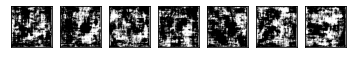

Epoch 2/100
12/12 [==============================] - 12s 986ms/step - d_loss: 4.7668 - g_loss: 2.0773
Save checkpoint


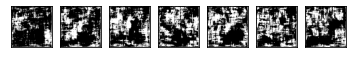

Epoch 3/100
12/12 [==============================] - 11s 987ms/step - d_loss: 2.8668 - g_loss: 2.0434
Save checkpoint


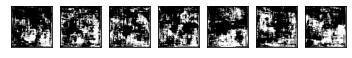

Epoch 4/100
12/12 [==============================] - 11s 949ms/step - d_loss: 2.1880 - g_loss: 1.8745
Save checkpoint


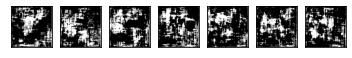

Epoch 5/100
12/12 [==============================] - 11s 950ms/step - d_loss: 1.9756 - g_loss: 1.6544
Save checkpoint


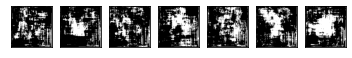

Epoch 6/100
12/12 [==============================] - 11s 949ms/step - d_loss: 1.9126 - g_loss: 1.9828
Save checkpoint


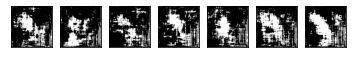

Epoch 7/100
12/12 [==============================] - 11s 948ms/step - d_loss: 1.5848 - g_loss: 2.0444
Save checkpoint


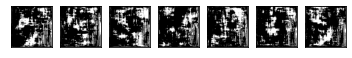

Epoch 8/100
12/12 [==============================] - 11s 949ms/step - d_loss: 1.6586 - g_loss: 2.3694
Save checkpoint


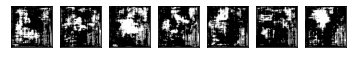

Epoch 9/100
12/12 [==============================] - 11s 950ms/step - d_loss: 1.2462 - g_loss: 2.4032
Save checkpoint


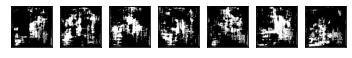

Epoch 10/100
12/12 [==============================] - 11s 950ms/step - d_loss: 1.2783 - g_loss: 2.3987
Save checkpoint


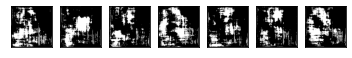

Epoch 11/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.3365 - g_loss: 2.7825
Save checkpoint


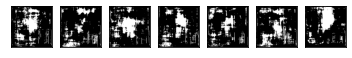

Epoch 12/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.4391 - g_loss: 2.4520
Save checkpoint


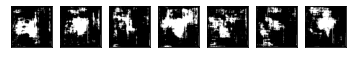

Epoch 13/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.4102 - g_loss: 2.4844
Save checkpoint


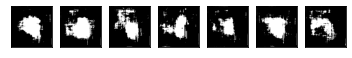

Epoch 14/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.3527 - g_loss: 2.2226
Save checkpoint


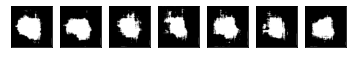

Epoch 15/100
12/12 [==============================] - 12s 991ms/step - d_loss: 1.4157 - g_loss: 2.0460
Save checkpoint


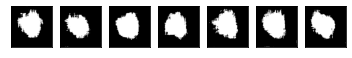

Epoch 16/100
12/12 [==============================] - 11s 991ms/step - d_loss: 1.2965 - g_loss: 2.3084
Save checkpoint


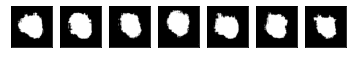

Epoch 17/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.2941 - g_loss: 1.8694
Save checkpoint


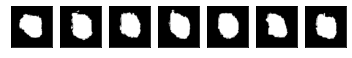

Epoch 18/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.3289 - g_loss: 1.6770
Save checkpoint


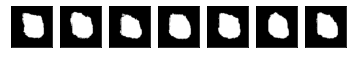

Epoch 19/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.5173 - g_loss: 2.0037
Save checkpoint


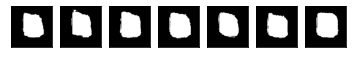

Epoch 20/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.5060 - g_loss: 1.8596
Save checkpoint


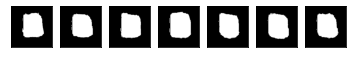

Epoch 21/100
12/12 [==============================] - 11s 954ms/step - d_loss: 1.3057 - g_loss: 1.7737
Save checkpoint


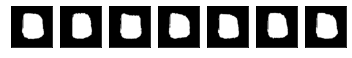

Epoch 22/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.5341 - g_loss: 1.9456
Save checkpoint


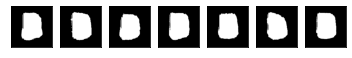

Epoch 23/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.4159 - g_loss: 1.9601
Save checkpoint


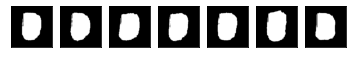

Epoch 24/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.2891 - g_loss: 1.8486
Save checkpoint


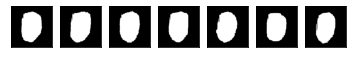

Epoch 25/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.4534 - g_loss: 1.9984
Save checkpoint


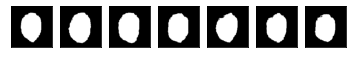

Epoch 26/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.5547 - g_loss: 1.5430
Save checkpoint


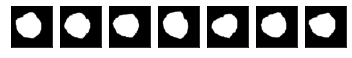

Epoch 27/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.4763 - g_loss: 1.6801
Save checkpoint


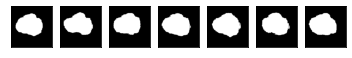

Epoch 28/100
12/12 [==============================] - 12s 991ms/step - d_loss: 1.6280 - g_loss: 1.9583
Save checkpoint


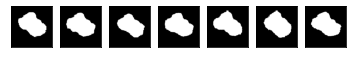

Epoch 29/100
12/12 [==============================] - 11s 991ms/step - d_loss: 1.5189 - g_loss: 1.5845
Save checkpoint


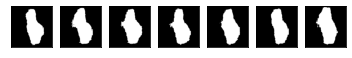

Epoch 30/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.1906 - g_loss: 1.7405
Save checkpoint


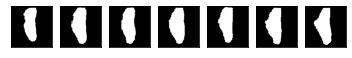

Epoch 31/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.3634 - g_loss: 1.9168
Save checkpoint


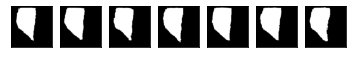

Epoch 32/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.3765 - g_loss: 2.1374
Save checkpoint


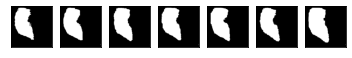

Epoch 33/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.4196 - g_loss: 2.4124
Save checkpoint


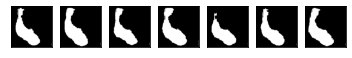

Epoch 34/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.7050 - g_loss: 2.4356
Save checkpoint


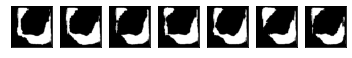

Epoch 35/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.4368 - g_loss: 2.6263
Save checkpoint


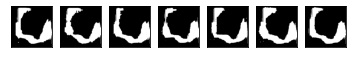

Epoch 36/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.1341 - g_loss: 2.4817
Save checkpoint


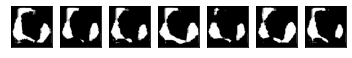

Epoch 37/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.0689 - g_loss: 2.5376
Save checkpoint


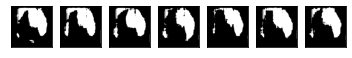

Epoch 38/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.0680 - g_loss: 1.8701
Save checkpoint


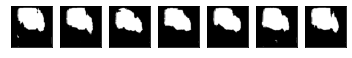

Epoch 39/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.5452 - g_loss: 1.5362
Save checkpoint


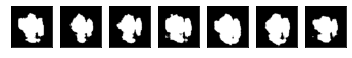

Epoch 40/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.4216 - g_loss: 1.6488
Save checkpoint


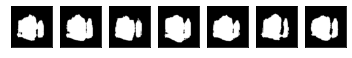

Epoch 41/100
12/12 [==============================] - 12s 991ms/step - d_loss: 1.2722 - g_loss: 1.6205
Save checkpoint


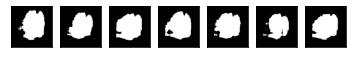

Epoch 42/100
12/12 [==============================] - 11s 990ms/step - d_loss: 1.3975 - g_loss: 1.7016
Save checkpoint


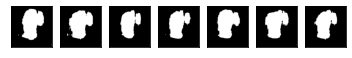

Epoch 43/100
12/12 [==============================] - 11s 951ms/step - d_loss: 1.3707 - g_loss: 1.4969
Save checkpoint


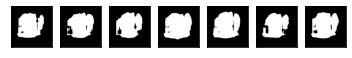

Epoch 44/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.2032 - g_loss: 1.8458
Save checkpoint


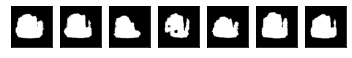

Epoch 45/100
12/12 [==============================] - 11s 953ms/step - d_loss: 1.2141 - g_loss: 1.8541
Save checkpoint


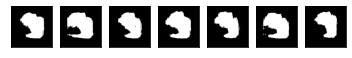

Epoch 46/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.1820 - g_loss: 2.1546
Save checkpoint


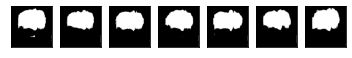

Epoch 47/100
12/12 [==============================] - 11s 953ms/step - d_loss: 1.1291 - g_loss: 1.8158
Save checkpoint


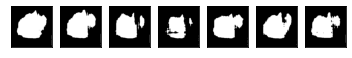

Epoch 48/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.1081 - g_loss: 2.1215
Save checkpoint


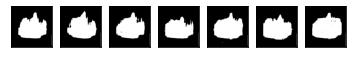

Epoch 49/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.0163 - g_loss: 1.8552
Save checkpoint


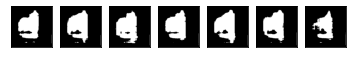

Epoch 50/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.8854 - g_loss: 1.7561
Save checkpoint


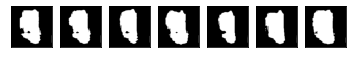

Epoch 51/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.9687 - g_loss: 1.8165
Save checkpoint


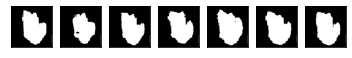

Epoch 52/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.0036 - g_loss: 1.6623
Save checkpoint


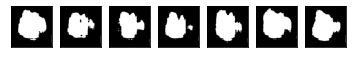

Epoch 53/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.9846 - g_loss: 2.0289
Save checkpoint


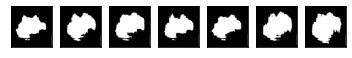

Epoch 54/100
12/12 [==============================] - 12s 992ms/step - d_loss: 0.9480 - g_loss: 1.9375
Save checkpoint


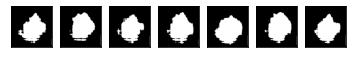

Epoch 55/100
12/12 [==============================] - 11s 992ms/step - d_loss: 0.8983 - g_loss: 1.8637
Save checkpoint


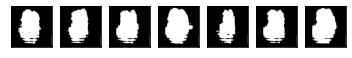

Epoch 56/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.9996 - g_loss: 2.1284
Save checkpoint


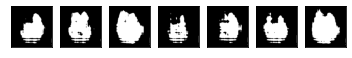

Epoch 57/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.1371 - g_loss: 1.8162
Save checkpoint


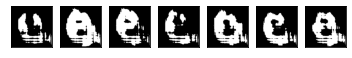

Epoch 58/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.8427 - g_loss: 2.0790
Save checkpoint


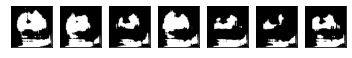

Epoch 59/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.8744 - g_loss: 2.1969
Save checkpoint


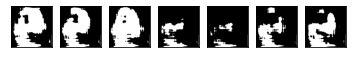

Epoch 60/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.9890 - g_loss: 1.9428
Save checkpoint


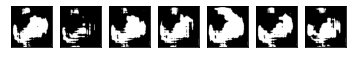

Epoch 61/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.7361 - g_loss: 2.0106
Save checkpoint


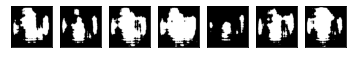

Epoch 62/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.9378 - g_loss: 1.9099
Save checkpoint


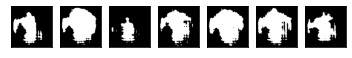

Epoch 63/100
12/12 [==============================] - 11s 951ms/step - d_loss: 0.9978 - g_loss: 1.7786
Save checkpoint


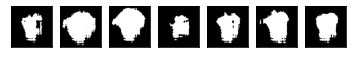

Epoch 64/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.9999 - g_loss: 2.1702
Save checkpoint


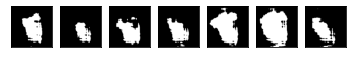

Epoch 65/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.8053 - g_loss: 2.1181
Save checkpoint


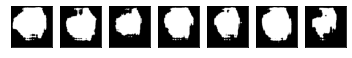

Epoch 66/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.9048 - g_loss: 1.8932
Save checkpoint


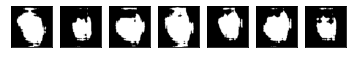

Epoch 67/100
12/12 [==============================] - 12s 991ms/step - d_loss: 0.9868 - g_loss: 2.2390
Save checkpoint


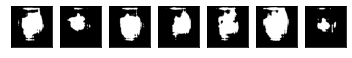

Epoch 68/100
12/12 [==============================] - 11s 991ms/step - d_loss: 0.7764 - g_loss: 2.2249
Save checkpoint


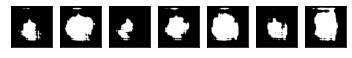

Epoch 69/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.9335 - g_loss: 1.9914
Save checkpoint


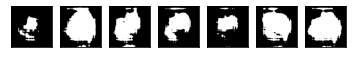

Epoch 70/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.0754 - g_loss: 2.0330
Save checkpoint


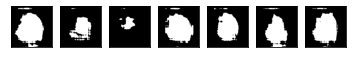

Epoch 71/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.7268 - g_loss: 2.0088
Save checkpoint


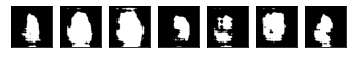

Epoch 72/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.7851 - g_loss: 2.4340
Save checkpoint


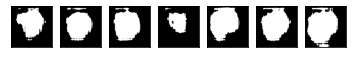

Epoch 73/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.9119 - g_loss: 2.5106
Save checkpoint


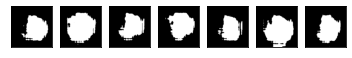

Epoch 74/100
12/12 [==============================] - 11s 951ms/step - d_loss: 0.7868 - g_loss: 2.3562
Save checkpoint


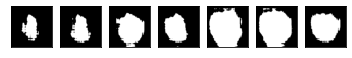

Epoch 75/100
12/12 [==============================] - 11s 951ms/step - d_loss: 0.7619 - g_loss: 2.1564
Save checkpoint


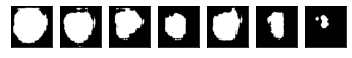

Epoch 76/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.7759 - g_loss: 2.0107
Save checkpoint


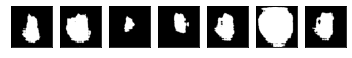

Epoch 77/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.9584 - g_loss: 1.7382
Save checkpoint


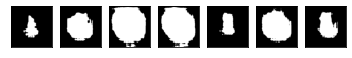

Epoch 78/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.7290 - g_loss: 2.1853
Save checkpoint


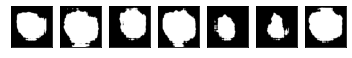

Epoch 79/100
12/12 [==============================] - 11s 952ms/step - d_loss: 1.0155 - g_loss: 2.7482
Save checkpoint


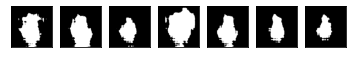

Epoch 80/100
12/12 [==============================] - 12s 991ms/step - d_loss: 0.7716 - g_loss: 2.1059
Save checkpoint


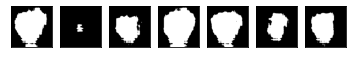

Epoch 81/100
12/12 [==============================] - 11s 990ms/step - d_loss: 0.6975 - g_loss: 2.3248
Save checkpoint


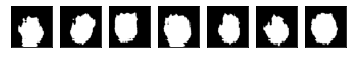

Epoch 82/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.9756 - g_loss: 2.7596
Save checkpoint


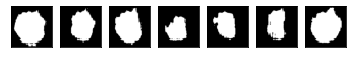

Epoch 83/100
12/12 [==============================] - 11s 951ms/step - d_loss: 0.8418 - g_loss: 2.1170
Save checkpoint


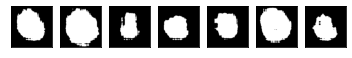

Epoch 84/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.5808 - g_loss: 2.2657
Save checkpoint


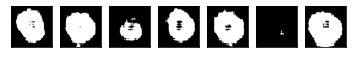

Epoch 85/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.7617 - g_loss: 1.9516
Save checkpoint


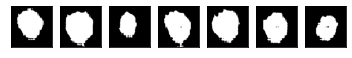

Epoch 86/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.9722 - g_loss: 2.3347
Save checkpoint


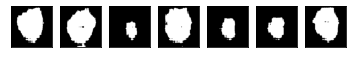

Epoch 87/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.8732 - g_loss: 2.2368
Save checkpoint


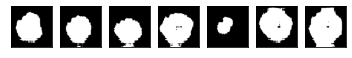

Epoch 88/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.7394 - g_loss: 1.9673
Save checkpoint


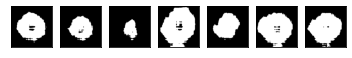

Epoch 89/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.6785 - g_loss: 2.4381
Save checkpoint


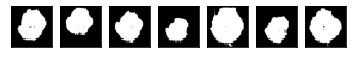

Epoch 90/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.6886 - g_loss: 2.7158
Save checkpoint


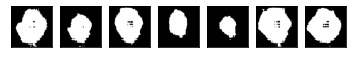

Epoch 91/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.5862 - g_loss: 2.3637
Save checkpoint


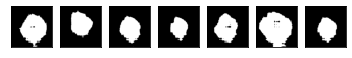

Epoch 92/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.7054 - g_loss: 2.2848
Save checkpoint


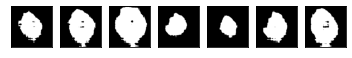

Epoch 93/100
12/12 [==============================] - 12s 991ms/step - d_loss: 0.6994 - g_loss: 2.3193
Save checkpoint


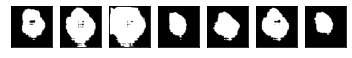

Epoch 94/100
12/12 [==============================] - 11s 991ms/step - d_loss: 0.7082 - g_loss: 2.2613
Save checkpoint


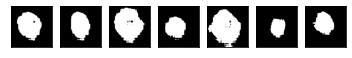

Epoch 95/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.8313 - g_loss: 2.1938
Save checkpoint


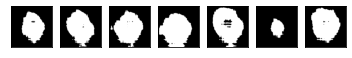

Epoch 96/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.6837 - g_loss: 2.4626
Save checkpoint


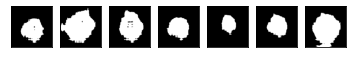

Epoch 97/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.6979 - g_loss: 2.3768
Save checkpoint


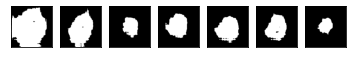

Epoch 98/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.8172 - g_loss: 2.3544
Save checkpoint


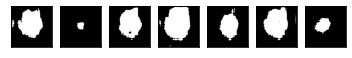

Epoch 99/100
12/12 [==============================] - 11s 952ms/step - d_loss: 0.7559 - g_loss: 2.3068
Save checkpoint


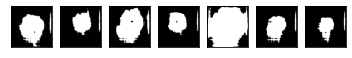

Epoch 100/100
12/12 [==============================] - 11s 953ms/step - d_loss: 0.7132 - g_loss: 2.4947
Save checkpoint


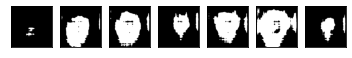

In [134]:
gan.compile(
    d_optimizer=generator_optimizer,
    g_optimizer=discriminator_optimizer,
    d_loss=discriminator_loss,
    g_loss=generator_loss,
)
gan.fit(train_masks,
        batch_size=BATCH_SIZE,
        shuffle=False,
        epochs=100,
        steps_per_epoch=ceil(IMAGES_COUNT//BATCH_SIZE),
        callbacks=[save_callback, board_callback, image_callback]
        )

In [1]:
%load_ext tensorboard
%tensorboard --logdir wgan/logs/